In [1]:
# Analyze fatal law enforcement incidents by type of agency
# 
# This notebook is the core analysis that answers the central research question:
# Are sheriff's offices involved in lethal force incidents at a higher rate than police departments?
# 
# Key analysis:
# - Calculates incident rates per 100,000 arrests by agency type
# - Uses arrests as the denominator because it approximates police-public interactions
# - Compares trends over time (2013-2022)
# - Produces the main finding for the CBS Reports documentary

In [2]:
# Import required libraries
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# Set up plotting style and pandas display options for better output
plt.style.use('seaborn-v0_8-white')
pd.set_option('display.max_columns', 100)

In [4]:
# Load the flagged incidents data created in the cleaning notebooks
# This data contains all Mapping Police Violence incidents with flags indicating
# whether they involved sheriffs, police, or other agencies

incidents_flagged = pd.read_csv(
    '../outputs/incidents_flagged.csv',
    parse_dates=["date"]  # Updated to use new column name
)

print(f"Loaded {len(incidents_flagged)} flagged incidents")
print(f"Sheriff incidents: {incidents_flagged['sheriff'].sum()}")
print(f"Police incidents: {incidents_flagged['police'].sum()}")
print(f"Other incidents: {incidents_flagged['others'].sum()}")

incidents_flagged.head(3)

Loaded 14676 flagged incidents
Sheriff incidents: 4384
Police incidents: 10170
Other incidents: 768


,incident_uid,name,age,gender,race,victim_image,date,street_address,city,state,zip,county,agency_responsible,ori,cause_of_death,circumstances,disposition_official,officer_charged,news_urls,signs_of_mental_illness,allegedly_armed,wapo_armed,wapo_threat_level,wapo_flee,wapo_body_camera,wapo_id,off_duty_killing,geography,fe_id,encounter_type,initial_reason,officer_names,officer_races,officer_known_past_shootings,call_for_service,tract,urban_rural_uspsai,urban_rural_nchs,hhincome_median_census_tract,latitude,longitude,pop_total_census_tract,pop_white_census_tract,pop_black_census_tract,pop_native_american_census_tract,pop_asian_census_tract,pop_pacific_islander_census_tract,pop_other_multiple_census_tract,pop_hispanic_census_tract,congressional_district_113,congressperson_lastname,congressperson_firstname,congressperson_party,prosecutor_head,prosecutor_race,prosecutor_gender,prosecutor_party,prosecutor_term,prosecutor_in_court,prosecutor_special,independent_investigation,prosecutor_url,sheriff_ori,police_ori,has_sheriff_in_name,has_police_in_name,sheriff,police,others
0,0,David Bahrami,26.0,Male,White,https://antiochherald.com/wp-content/uploads/2...,2025-06-30,3841 Osprey Dr,Antioch,California,NaN,NaN,Antioch Police Department,CA0070100,Gunshot,The victim called 911 and reported he was goin...,Pending Investigation,NaN,https://abc7news.com/post/antioch-police-fatal...,No,Allegedly Armed,Knife,Sudden Threatening Movement,Not Fleeing,Yes,NaN,NaN,NaN,NaN,Person with a Weapon,threatening individuals (armed),"Merrill, Lorono,",NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,True,False
1,1,Daphine Mae Jennings,58.0,Female,White,NaN,2025-06-30,200 block of Mountain Laurel Drive,La Grange,Georgia,NaN,NaN,Troup County Sheriff's Office,GA1410000,Gunshot,Officers responded to a call from a woman who ...,Pending Investigation,NaN,https://www.fox5atlanta.com/news/woman-shot-tr...,Yes,Allegedly Armed,Gun,Brandished Weapon,Not Fleeing,NaN,NaN,NaN,NaN,NaN,Mental Health/Welfare Check,suicidal and threatening violence (armed),NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,True,False,False
2,2,Joshua B. Coffey,48.0,Male,White,NaN,2025-06-30,1400 block of South Third Street,Niles,Michigan,NaN,NaN,Berrien County Sheriff's Office,MI1111100,Gunshot,Police report that an officer approached a par...,Pending Investigation,NaN,https://wsbt.com/news/local/police-investigati...,No,Allegedly Armed,Gun,Attack,Foot,Yes,NaN,NaN,NaN,NaN,Person with a Weapon,Suspicious Vehicle,Cal Landon,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,False,True,False,False


In [5]:
# Aggregate incidents by year and agency type
# This creates annual counts of incidents for each agency type, which will be our numerator
# when calculating incident rates (incidents per arrest)

sheriff_incidents = (
    incidents_flagged
    .assign(
        year = lambda f: f["date"].dt.year,  # Updated to use new column name
    )
    [["incident_uid", "state", "year", "sheriff", "police", "others"]]  # Updated column names to match CSV
    .groupby("year")
    .agg(
        total_involved = ("incident_uid", "count"),    # Total incidents per year
        sheriff_involved = ("sheriff", "sum"),         # Sheriff incidents per year
        police_involved = ("police", "sum"),           # Police incidents per year
        others_involved = ("others", "sum"),           # Other agency incidents per year
    )
    .reset_index()
)

print(f"Created annual incident counts for {len(sheriff_incidents)} years")
print(f"Years covered: {sheriff_incidents['year'].min()} to {sheriff_incidents['year'].max()}")
sheriff_incidents.head()

Created annual incident counts for 14 years
Years covered: 2012 to 2025


,year,total_involved,sheriff_involved,police_involved,others_involved
0,2012,1,0,1,0
1,2013,1075,283,769,50
2,2014,1038,293,734,50
3,2015,1104,295,785,60
4,2016,1068,304,730,58


In [6]:
# Calculate incident rates per 100,000 arrests by agency type
# 
# THIS IS THE KEY CALCULATION FOR THE ENTIRE ANALYSIS
# 
# We merge arrests data (denominator) with incidents data (numerator) to calculate:
# - Incidents per 100,000 arrests for sheriffs vs police
# - This rate controls for the level of police-public interaction
# - Higher rates indicate more lethal force incidents per arrest made
# 
# Why arrests as denominator?
# - Arrests approximate police-public interactions better than population or officer count
# - Standardizes comparison across different types of agencies
# - Accounts for how active each agency type is in the field

incidents_arrests = (
    pd
    .read_csv(
        "../outputs/arrests_by_year.csv",
    )
    .merge(
        sheriff_incidents,
        on = "year"
    )
    .assign(
        # Calculate incidents per 100,000 arrests for each agency type
        sheriff_incidents_per_arrest = lambda f: f["sheriff_involved"] / f["sheriffs office"] * 100000,
        police_incidents_per_arrest = lambda f: f["police_involved"] / f["local police department"] * 100000,
        other_incidents_per_arrest = lambda f: f["others_involved"] / f["other"] * 100000,
    )
    .set_index("year")
    .sort_index(ascending = False)  # Show most recent years first
)

print("MAIN FINDING:")
print("Incident rates per 100,000 arrests show sheriff's offices have consistently higher rates")
print("\nMost recent data (2022):")
latest_year = incidents_arrests.index.max()
sheriff_rate = incidents_arrests.loc[latest_year, "sheriff_incidents_per_arrest"]
police_rate = incidents_arrests.loc[latest_year, "police_incidents_per_arrest"]
print(f"Sheriff's offices: {sheriff_rate:.1f} per 100,000 arrests")
print(f"Police departments: {police_rate:.1f} per 100,000 arrests")
print(f"Sheriff rate is {sheriff_rate/police_rate:.1f}x higher than police rate")

incidents_arrests.head()

MAIN FINDING:
Incident rates per 100,000 arrests show sheriff's offices have consistently higher rates

Most recent data (2022):
Sheriff's offices: 27.4 per 100,000 arrests
Police departments: 10.0 per 100,000 arrests
Sheriff rate is 2.7x higher than police rate


,local police department,sheriffs office,other,total_involved,sheriff_involved,police_involved,others_involved,sheriff_incidents_per_arrest,police_incidents_per_arrest,other_incidents_per_arrest
year,,,,,,,,,,
2022,8259304.0,1549006.0,54961.0,1269,425,830,74,27.436950,10.049273,134.640927
2021,5596708.0,1160712.0,7950.0,1190,359,837,63,30.929292,14.955220,792.452830
2020,7793940.0,1577127.0,60384.0,1160,367,772,72,23.270162,9.905131,119.236884
2019,8372321.0,1606112.0,70784.0,1116,325,759,70,20.235202,9.065586,98.892405
2018,8624655.0,1650045.0,71993.0,1152,327,802,64,19.817641,9.298923,88.897532


In [7]:
# Save the incident rate data for use in other notebooks and reporting
# This is a key output dataset that contains the main findings of the analysis

incidents_arrests.to_csv("../outputs/incident_rate_by_arrest_year.csv", index = True)
print("Saved incident rate data to ../outputs/incident_rate_by_arrest_year.csv")
print("This file contains the main findings: incident rates per 100,000 arrests by agency type and year")

Saved incident rate data to ../outputs/incident_rate_by_arrest_year.csv
This file contains the main findings: incident rates per 100,000 arrests by agency type and year


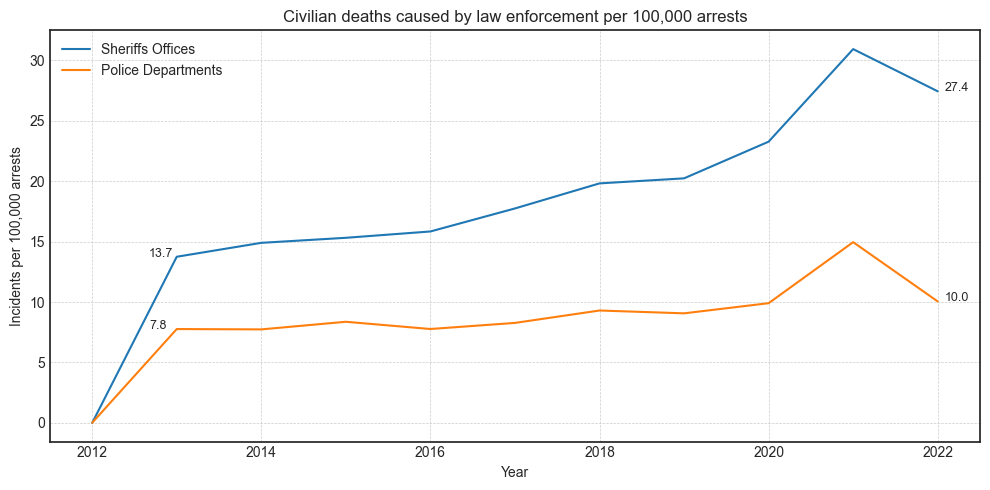


Key takeaways from this chart:
1. Sheriff's offices have consistently higher incident rates than police departments
2. Both rates have increased over the decade, but sheriff rates increased more dramatically
3. In 2022, sheriff's offices had nearly 3x higher incident rates than police departments


In [8]:
# Create the main visualization showing incident rates over time
# This chart is the key visual for the CBS Reports documentary, showing:
# - Sheriff's offices consistently have higher incident rates than police
# - Both rates have increased over time, but sheriff rates have increased more
# - The gap between sheriff and police rates has widened

ax = (
    incidents_arrests
    [["sheriff_incidents_per_arrest", "police_incidents_per_arrest"]]
    .plot(
        kind = "line",
        title = "Civilian deaths caused by law enforcement per 100,000 arrests",
        ylabel = "Incidents per 100,000 arrests",
        xlabel = "Year",
        figsize = (10, 5),
    )
)

# Add data labels at the beginning and end of each line for clarity
for i, y in enumerate(["sheriff_incidents_per_arrest", "police_incidents_per_arrest"]):
    y_13 = incidents_arrests.loc[2013, y]
    y_22 = incidents_arrests.loc[2022, y]
    
    # Label for 2013 (start of line)
    ax.annotate(
        f"{y_13:.1f}",
        xy = (2013, y_13),
        xytext = (-20, 0),
        fontsize = 9,
        textcoords = "offset points",
    )

    # Label for 2022 (end of line)
    ax.annotate(
        f"{y_22:.1f}",
        xy = (2022, y_22),
        xytext = (5, 0),
        fontsize = 9,
        textcoords = "offset points",
    )

# Clean up the chart
ax.legend(["Sheriffs Offices", "Police Departments"])
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\nKey takeaways from this chart:")
print("1. Sheriff's offices have consistently higher incident rates than police departments")
print("2. Both rates have increased over the decade, but sheriff rates increased more dramatically") 
print("3. In 2022, sheriff's offices had nearly 3x higher incident rates than police departments")

In [9]:
# Calculate percentage changes in incident rates from 2013 to 2022
# This shows how much the rates have changed over the decade and quantifies
# the increasing disparity between sheriff and police incident rates

sheriff_2013 = incidents_arrests.loc[2013, "sheriff_incidents_per_arrest"]
sheriff_2022 = incidents_arrests.loc[2022, "sheriff_incidents_per_arrest"] 
sheriff_change = (sheriff_2022 - sheriff_2013) / sheriff_2013 * 100

police_2013 = incidents_arrests.loc[2013, "police_incidents_per_arrest"]
police_2022 = incidents_arrests.loc[2022, "police_incidents_per_arrest"]
police_change = (police_2022 - police_2013) / police_2013 * 100

print(f"Change in incident rates from 2013 to 2022:")
print(f"Sheriff's offices: {sheriff_2013:.1f} → {sheriff_2022:.1f} ({sheriff_change:+.0f}% change)")
print(f"Police departments: {police_2013:.1f} → {police_2022:.1f} ({police_change:+.0f}% change)")
print(f"\nSheriff rates increased {sheriff_change/police_change:.1f}x faster than police rates")

Change in incident rates from 2013 to 2022:
Sheriff's offices: 13.7 → 27.4 (+100% change)
Police departments: 7.8 → 10.0 (+29% change)

Sheriff rates increased 3.4x faster than police rates


In [10]:
# Display the headline finding for 2022 (most recent complete year)
# This is the key statistic that drives the CBS Reports documentary

print(f"""
MAIN FINDING - Lethal incidents per 100,000 arrests in 2022:

• Sheriff's Offices: {sheriff_2022:.1f} incidents per 100,000 arrests
• Police Departments: {police_2022:.1f} incidents per 100,000 arrests

Sheriff's offices have a rate {sheriff_2022/police_2022:.1f} times higher than police departments.

This means that for every 100,000 arrests made, sheriff's offices are involved in 
{sheriff_2022:.1f} lethal force incidents compared to {police_2022:.1f} for police departments.
""")


MAIN FINDING - Lethal incidents per 100,000 arrests in 2022:

• Sheriff's Offices: 27.4 incidents per 100,000 arrests
• Police Departments: 10.0 incidents per 100,000 arrests

Sheriff's offices have a rate 2.7 times higher than police departments.

This means that for every 100,000 arrests made, sheriff's offices are involved in 
27.4 lethal force incidents compared to 10.0 for police departments.



In [11]:
# Display the trend analysis showing how rates have changed over time
# This provides context about whether the disparity is growing or shrinking

print(f"""
TREND ANALYSIS - Change from 2013 to 2022:

• Sheriff Offices: {sheriff_change:.0f}% increase ({sheriff_2013:.1f} → {sheriff_2022:.1f})
• Police Departments: {police_change:.0f}% increase ({police_2013:.1f} → {police_2022:.1f})

Key insight: Sheriff incident rates have increased {sheriff_change/police_change:.1f} times faster 
than police rates, meaning the disparity between the two is growing over time.

This suggests the problem may be getting worse, not better.
""")


TREND ANALYSIS - Change from 2013 to 2022:

• Sheriff Offices: 100% increase (13.7 → 27.4)
• Police Departments: 29% increase (7.8 → 10.0)

Key insight: Sheriff incident rates have increased 3.4 times faster 
than police rates, meaning the disparity between the two is growing over time.

This suggests the problem may be getting worse, not better.



---
---
---